In [127]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np
import pickle
import torch
from torch import nn
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import os
import sys

current_dir = os.path.dirname(os.path.abspath('__file__'))
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)
from dataHandler.preprocessor import Preprocessor
from sklearn import model_selection

print(torch.__version__)

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

2.3.0+cu121
Using cpu device


__Getting data__

In [128]:
directory = "/home/michal/Desktop/UniversityOfEssex/MasterProject/22-24_CE901-CE911-CF981-SU_kaczmarczyk_michal_p/data/Bloomberg/"
files = os.listdir(directory)
files = [f for f in files if os.path.isfile(directory+'/'+f)]
files
files = ["RR.L.csv"]

In [129]:
dataDir = "/home/michal/Desktop/UniversityOfEssex/MasterProject/22-24_CE901-CE911-CF981-SU_kaczmarczyk_michal_p/data/data/"
dataset = []
for file in files:
    df = pd.read_csv(dataDir + file).set_index("Date")
    df.index = pd.to_datetime(df.index)
    bl = pd.read_csv(directory + file).set_index("Date")
    bl.index = pd.to_datetime(bl.index)
    bl = bl["Price Earnings Ratio \n(P/E) \n(RR/ LN Equity)"]
    bl = bl.resample('D')
    bl = bl.ffill()
    bl = bl.bfill()
    df = df.join(bl, how="inner")
    dataset.append(df)

__Splitting Dataset__

In [130]:
trainDataset = []
testDataset = []
preprocessor = Preprocessor()
i=0
for df in dataset:
    df.insert(0, "Date", df.index)
    df = preprocessor.leaveDataSinceDate(df)
    #if files[i] == "RR.L.csv":
    train, test = model_selection.train_test_split(df, test_size=0.2, shuffle=False)
    trainDataset.append(train)
    testDataset.append(test)
    #else:
    #    trainDataset.append(df)
    i+=1

__Preprocessing__

In [131]:
preprocessor = Preprocessor()
for i in range(len(trainDataset)):
    trainDataset[i] = preprocessor.dropUnnamedColumn(trainDataset[i])
    trainDataset[i] = preprocessor.dropDuplicates(trainDataset[i])
    trainDataset[i] = preprocessor.addChangeFeature(trainDataset[i])
    columns = trainDataset[i].columns
    trainDataset[i][columns[1:]] = preprocessor.fillMissingData(trainDataset[i][columns[1:]])
    trainDataset[i][columns[1:]] = preprocessor.scaleData(trainDataset[i][columns[1:]])
    trainDataset[i] = preprocessor.sortValuesByDate(trainDataset[i])
    trainDataset[i].set_index("Date", inplace = True)

In [132]:
preprocessor = Preprocessor()
for i in range(len(testDataset)):
    testDataset[i] = preprocessor.dropUnnamedColumn(testDataset[i])
    testDataset[i] = preprocessor.dropDuplicates(testDataset[i])
    testDataset[i] = preprocessor.addChangeFeature(testDataset[i])
    columns = testDataset[i].columns
    testDataset[i][columns[1:]] = preprocessor.fillMissingData(testDataset[i][columns[1:]])
    testDataset[i][columns[1:]] = preprocessor.scaleData(testDataset[i][columns[1:]])
    testDataset[i] = preprocessor.sortValuesByDate(testDataset[i])
    testDataset[i].set_index("Date", inplace = True)

preprocessor.saveScalers()

__Date Embedding and cyclical transformation__

In [133]:

def getDateRange(start_date, end_date):
    current_date = start_date
    dates = []
    while current_date <= end_date:
        dates.append(current_date.strftime('%Y-%m-%d'))
        current_date += timedelta(days=1)
    return dates

# Define the date range
start_date = datetime(2024, 5, 24) - timedelta(days=40*365)  # 40 years ago
end_date = datetime(2024, 5, 24) + timedelta(days=40*365)    # 40 years in the future

# Generate the list of dates
dictionary = getDateRange(start_date, end_date)
date_to_index = {date: index for index, date in enumerate(dictionary)}

class DateEmbeddingModel(nn.Module):
    def __init__(self, num_embeddings = 29201, embedding_dim = 8):
        super(DateEmbeddingModel, self).__init__()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)

    def forward(self, dates):
        date_indices = torch.tensor([date_to_index[date] for date in dates], dtype=torch.long)
        embedded_dates = self.embedding(date_indices)
        return embedded_dates

In [134]:
def dateCyclicalTransformation(date):
    date = pd.to_datetime(date)

    monthSin = np.sin(2 * np.pi * date.month/12.0)
    monthCos = np.cos(2 * np.pi * date.month/12.0)
    daySin = np.sin(2 * np.pi * date.day/31.0)
    dayCos = np.cos(2 * np.pi * date.day/31.0)

    return [monthSin, monthCos, daySin, dayCos]

In [135]:
'''date = train.index.map(dateCyclicalTransformation)
date = pd.DataFrame(date.to_list(), columns = ["monthSin", "monthCos", "daySin", "dayCos"]).set_index(train.index)
train = train.join(date)

date = validation.index.map(dateCyclicalTransformation)
date = pd.DataFrame(date.to_list(), columns = ["monthSin", "monthCos", "daySin", "dayCos"]).set_index(validation.index)
validation = validation.join(date)

date = test.index.map(dateCyclicalTransformation)
date = pd.DataFrame(date.to_list(), columns = ["monthSin", "monthCos", "daySin", "dayCos"]).set_index(test.index)
test = test.join(date)'''

'date = train.index.map(dateCyclicalTransformation)\ndate = pd.DataFrame(date.to_list(), columns = ["monthSin", "monthCos", "daySin", "dayCos"]).set_index(train.index)\ntrain = train.join(date)\n\ndate = validation.index.map(dateCyclicalTransformation)\ndate = pd.DataFrame(date.to_list(), columns = ["monthSin", "monthCos", "daySin", "dayCos"]).set_index(validation.index)\nvalidation = validation.join(date)\n\ndate = test.index.map(dateCyclicalTransformation)\ndate = pd.DataFrame(date.to_list(), columns = ["monthSin", "monthCos", "daySin", "dayCos"]).set_index(test.index)\ntest = test.join(date)'

__Creating data loader__

In [136]:
def createSequence(dataX, dataY, lengthX, predictionHorizont):
    xData = []
    yData = []
    for i in range(len(dataX) - lengthX - predictionHorizont):
        xData.append(dataX[i:i+lengthX].values)
        yData.append(dataY[(lengthX + i):(lengthX + predictionHorizont + i)].values)
    return xData, yData

features = len(trainDataset[0].iloc[0])
samplesForPrediction = 5
samplesPredicted = 1

trainDates = trainDataset[0].index[samplesForPrediction+1:]
testDates = testDataset[0].index[samplesForPrediction+1:]
xTrain = []
yTrain = []
xTest = []
yTest = []
for df in trainDataset:
    trainX, trainY = createSequence(df, df["Close"], samplesForPrediction, samplesPredicted)
    xTrain += trainX
    yTrain += trainY
for df in testDataset:
    testX, testY = createSequence(df, df["Close"], samplesForPrediction, samplesPredicted)
    xTest += testX
    yTest += testY

__Model__

In [137]:
xTrain = np.array(xTrain)
yTrain = np.array(yTrain)
#xValidation = np.array(xValid)
#yValidation = np.array(yValid)
xTest = np.array(xTest)
yTest = np.array(yTest)

num_samples, num_days, num_features = xTrain.shape
xTrain_flattened = xTrain.reshape(num_samples, num_days * num_features)

#num_samples, num_days, num_features = xValidation.shape
#xValidation_flattened = xValidation.reshape(num_samples, num_days * num_features)

num_samples, num_days, num_features = xTest.shape
xTest_flattened = xTest.reshape(num_samples, num_days * num_features)

In [138]:
svr = SVR(kernel='linear', degree=10, C=10.0, epsilon=1e-5, max_iter=-1, tol = 1e-2)
svrMultiOutput = MultiOutputRegressor(svr)
svrMultiOutput.fit(xTrain_flattened, yTrain)
pickle.dump(svrMultiOutput, open("../models/svr_params.pickle", "wb"))

# Load the parameters from file
#svrMultiOutput = pickle.load(open("../models/svr_params.pickle", "rb"))


__Train results__

Total Mean Squared Error: 0.0002216692223866431
Total Mean Absolute Error: 0.01016091486991443


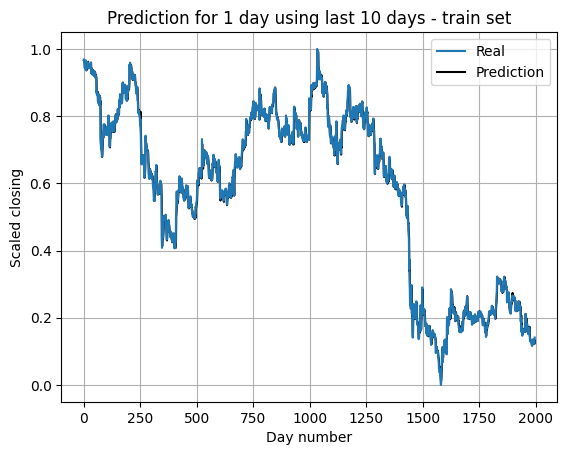

In [139]:
# Make predictions
y_pred = svrMultiOutput.predict(xTrain_flattened)

# Calculate the mean squared error across all outputs
mse_total = mean_squared_error(yTrain, y_pred)
print(f'Total Mean Squared Error: {mse_total}')

mae_total = mean_absolute_error(yTrain, y_pred)
print(f'Total Mean Absolute Error: {mae_total}')

set = 5*2
real = np.concatenate(yTrain[::1])
predictions = np.concatenate(y_pred[::1])

fig, ax = plt.subplots()
ax.plot(real, zorder = 3)
ax.plot(predictions, color = 'black', zorder = 2)
ax.legend(["Real", "Prediction"])
#ax.axvspan(0, 4, facecolor='lightblue', alpha=0.5, zorder = 1)  # First part
#ax.axvspan(4, 9, facecolor='lightgreen', alpha=0.5, zorder = 1)  # Second part
#ax.axvspan(9, 14, facecolor='tomato', alpha=0.5, zorder = 1)  # Second third
#ax.set_ylim([0, 1])
ax.grid()
plt.ylabel("Scaled closing")
plt.xlabel("Day number")
plt.title("Prediction for 1 day using last 10 days - train set")
plt.show()



__Test results__

In [140]:
# Make predictions
y_pred = svrMultiOutput.predict(xTest_flattened)

# Print the shape of predictions to verify
print(y_pred.shape)  # Should be (num_samples, prediction horizont)

(495, 1)


In [141]:
# Calculate the mean squared error across all outputs
mse_total = mean_squared_error(yTest, y_pred)
print(f'Total Mean Squared Error: {mse_total}')

mae_total = mean_absolute_error(yTest, y_pred)
print(f'Total Mean Absolute Error: {mae_total}')

Total Mean Squared Error: 0.0001709437121024047
Total Mean Absolute Error: 0.008756568805758246


/tmp/ipykernel_4732/205548134.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dummyDataset["Close"] = predictions
/tmp/ipykernel_4732/205548134.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dummyDataset["Close"] = real


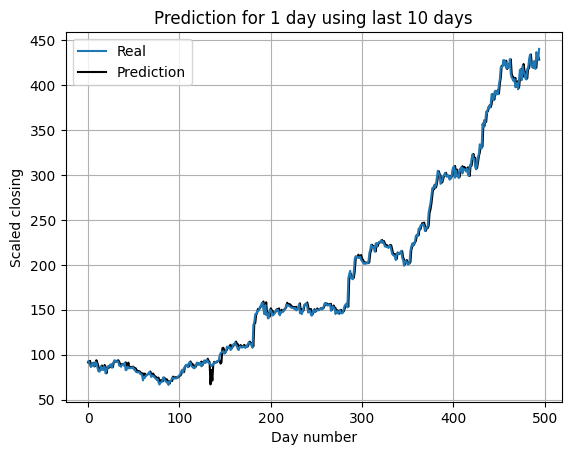

In [142]:
set = 5*2
real = np.concatenate(yTest[::1])
predictions = np.concatenate(y_pred[::1])

#Rescaling
dummyDataset = testDataset[0].tail(len(predictions))
dummyDataset["Close"] = predictions
dummyDataset = preprocessor.scaler.inverse_transform(dummyDataset)
predictions = dummyDataset[:,3]

dummyDataset = testDataset[0].tail(len(real))
dummyDataset["Close"] = real
dummyDataset = preprocessor.scaler.inverse_transform(dummyDataset)
real = dummyDataset[:,3]

fig, ax = plt.subplots()
ax.plot(real[:], zorder = 3)
ax.plot(predictions[:], color = 'black', zorder = 2)
ax.legend(["Real", "Prediction"])
#ax.axvspan(0, 4, facecolor='lightblue', alpha=0.5, zorder = 1)  # First part
#ax.axvspan(4, 9, facecolor='lightgreen', alpha=0.5, zorder = 1)  # Second part
#ax.axvspan(9, 14, facecolor='tomato', alpha=0.5, zorder = 1)  # Second third
#ax.set_ylim([0, 1])
ax.grid()
plt.ylabel("Scaled closing")
plt.xlabel("Day number")
plt.title("Prediction for 1 day using last 10 days")
plt.show()

__Profit calculation__

In [143]:
profit = 0
lastBuy = 0
action = []
for realVal, predVal in zip(real[:-samplesPredicted], predictions[samplesPredicted::samplesPredicted]):
    if(realVal<predVal and lastBuy == 0):
        lastBuy = realVal
        action.append(1)
    elif(realVal > predVal and lastBuy > 0):
        profit += realVal - lastBuy
        lastBuy = 0
        action.append(-1)
    else:
        action.append(0)

if(lastBuy>0):
    profit += realVal - lastBuy
    lastBuy = 0
    action.append(-1)
else:
    action.append(0)

print(profit)

371.9800469999999


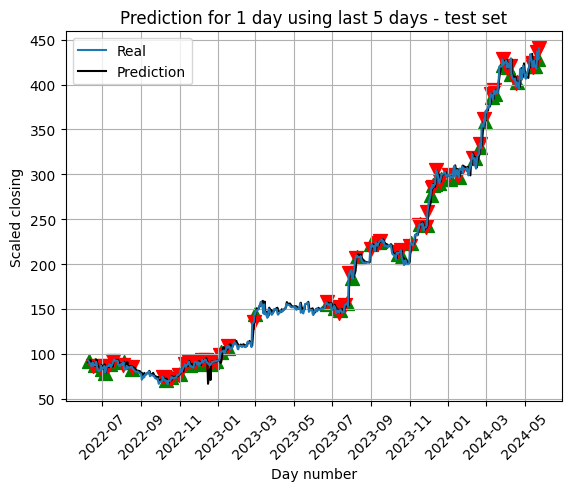

In [144]:
real = real[:]
predictions = predictions[:]
testDates = testDates[:]
action = np.array(action[:])

buy_dates = np.array(testDates)[action == 1]
sell_dates = np.array(testDates)[action == -1]

buy_prices = real[action == 1]
sell_prices = real[action == -1]

fig, ax = plt.subplots()
ax.plot(np.array(testDates), real, zorder = 3)
ax.plot(np.array(testDates), predictions, color = 'black', zorder = 2)

ax.scatter(buy_dates, buy_prices, color='green', marker='^', s=100, label='Buy')
ax.scatter(sell_dates, sell_prices, color='red', marker='v', s=100, label='Sell')

# Rotate date labels for better readability
plt.xticks(rotation=45)

# Optionally, set the locator to have fewer ticks
locator = plt.matplotlib.dates.AutoDateLocator(minticks=10, maxticks=20)
ax.xaxis.set_major_locator(locator)

ax.legend(["Real", "Prediction"])
ax.grid()
plt.ylabel("Scaled closing")
plt.xlabel("Day number")
plt.title("Prediction for 1 day using last 5 days - test set")
plt.show()

